<a href="https://colab.research.google.com/github/EgeBuyukbayram/Defect-Recognition/blob/main/Defect_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
import os
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm
from PIL import Image
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
os.chdir('/gdrive/My Drive/defect')


In [ ]:
os.getcwd()

'/gdrive/My Drive/defect'

In [ ]:
!ls

model_structure.png    severstal-steel-defect-detection.zip  train.csv
sample_submission.csv  test_images			     train_images


In [ ]:
data = pd.read_csv("train.csv")
data.shape

(7095, 3)

In [ ]:
file_name = 'train_images'

In [ ]:
data.columns

Index(['ImageId', 'ClassId', 'EncodedPixels'], dtype='object')

,count
ClassId,
3,5150
1,897
4,801
2,247


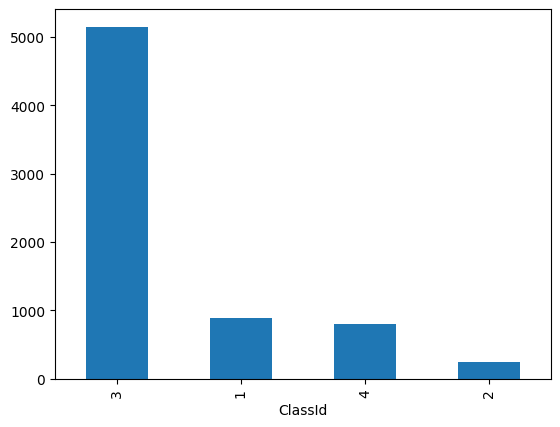

In [ ]:
data["ClassId"].value_counts().plot(kind='bar')
data["ClassId"].value_counts()

In [ ]:
classes = [3, 1, 4, 2]
balanced_data = []

for class_id in classes:
  class_data = data[data["ClassId"] == class_id]
  if len(class_data) > 800:
    class_data = class_data.sample(n=800, random_state=42)
  balanced_data.append(class_data)

balanced_data = pd.concat(balanced_data)
print(balanced_data["ClassId"].value_counts())

ClassId
3    800
1    800
4    800
2    247
Name: count, dtype: int64


In [ ]:
class_2_data = data[data["ClassId"] == 2]
len(class_2_data)

247

  0%|          | 0/4 [00:00<?, ?it/s]

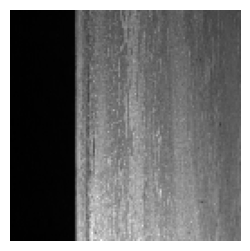

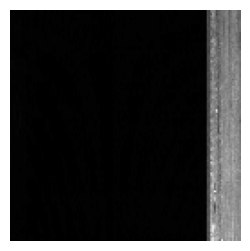

 50%|█████     | 2/4 [00:00<00:00, 13.02it/s]

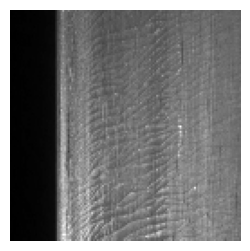

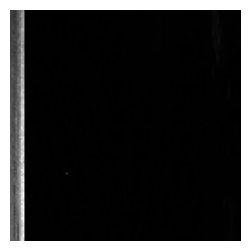

100%|██████████| 4/4 [00:00<00:00, 12.23it/s]


In [ ]:
for img, classId, encodedpixel in tqdm(class_2_data.values[:4]):
  image = cv2.imread(f"train_images/{img}", cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image, (128,128))
  plt.figure(figsize=(3,3))
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

In [ ]:
def rotate_image(image):
  (h, w) = image.shape[:2]

  rotations =np.arange(0, 180,10 )
  rotation_angle = np.random.choice(rotations)

  center = (w//2 , h//2)

  rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
  rotated_image = cv2.warpAffine(image, rotation_matrix, (w,h))
  return rotated_image

In [ ]:
augmented_images = []
count = 0
target = 800 - len(class_2_data)

for img, classId, encodedpixel in tqdm(class_2_data.values):
    if count >= target:
        break
    image = cv2.imread(f"train_images/{img}", cv2.IMREAD_GRAYSCALE)
    if image is None:
      print(f"Could not load image: train_images/{img}")
      continue
    image = cv2.resize(image, (128, 128))

    for _ in range(3):
        if count >= target:
            break
        count += 1

        augmented_images.append(rotate_image(image))

augmented_class_2_data = pd.DataFrame({
    "ImageId": [f"rotated_{i}.jpg" for i in range(len(augmented_images))],
    "ClassId": [2] * len(augmented_images),
    "images": augmented_images
})

 75%|███████▍  | 185/247 [00:02<00:00, 92.14it/s] 


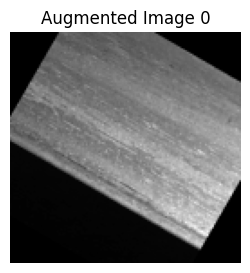

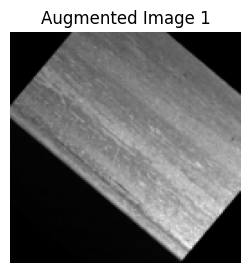

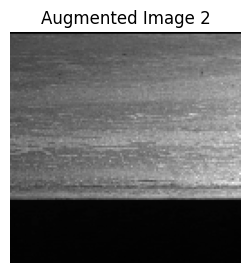

In [ ]:
for i, image in enumerate(augmented_images[:3]):
  plt.figure(figsize=(3,3))
  plt.imshow(image, cmap='gray')
  plt.title(f"Augmented Image {i}")
  plt.axis('off')
  plt.show()


In [ ]:
output_folder = '/gdrive/My Drive/defect/train_images'

os.makedirs(output_folder, exist_ok=True)

for i, rotated_image in enumerate(augmented_images):
    output_path = os.path.join(output_folder, f"rotated_{i}.jpg")
    if os.path.exists(output_path):
        continue
    cv2.imwrite(output_path, rotated_image)


In [ ]:
combiden_data = pd.concat([balanced_data, augmented_class_2_data])
combiden_data

,ImageId,ClassId,EncodedPixels,images
1650,3c7e032fc.jpg,3,304833 22 305089 22 305345 22 305601 22 305857...,NaN
6554,ebcfa79fd.jpg,3,9088 24 9323 53 9577 62 9832 71 10087 79 10341...,NaN
1526,385f6dc61.jpg,3,257089 6720 270337 32 270593 96 270849 160 271...,NaN
6619,ee346cc79.jpg,3,89089 43 89345 128 89601 213 89857 3072 92948 ...,NaN
6016,d7dba3a05.jpg,3,196353 64 196609 192 196865 19413 216321 128 2...,NaN
...,...,...,...,...
548,rotated_548.jpg,2,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
549,rotated_549.jpg,2,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
550,rotated_550.jpg,2,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
551,rotated_551.jpg,2,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
l1 = []
l2 = []

for img, ClassId, EncodedPixels,_ in tqdm(combiden_data.values):
  image = cv2.imread(f"train_images/{img}", cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image, (128,128))
  l1.append(image)
  l2.append(ClassId)

100%|██████████| 3200/3200 [00:20<00:00, 153.28it/s]


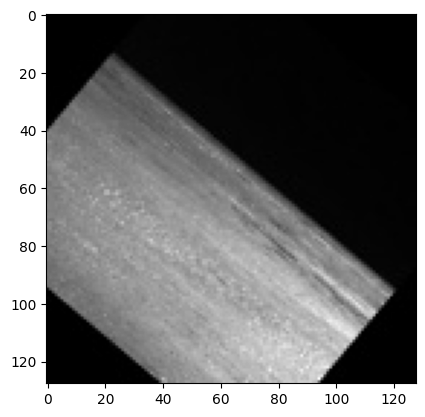

In [ ]:
i = 3190
plt.imshow(l1[i], cmap="gray")

In [ ]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = to_categorical(y)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 2240
Validation set size: 480
Test set size: 480


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, MaxPooling2D, SpatialDropout2D

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(128,128,1)))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 126, 126, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 126, 126, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_8                  │ (None, 126, 126, 64)        │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_9                  │ (None, 61, 61, 64)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_10                 │ (None, 28, 28, 32)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_11                 │ (None, 12, 12, 32)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 10, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 10, 10, 32)          │             128 │
│ (BatchNormalization)                 │                             │              

 Total params: 75,556 (295.14 KB)

 Trainable params: 75,108 (293.39 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])


In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=60,
    verbose="auto",
    validation_data=(X_val, y_val),
    shuffle=True
)

Epoch 1/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.3892 - loss: 1.3063 - val_accuracy: 0.2542 - val_loss: 1.4076
Epoch 2/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.5597 - loss: 1.0560 - val_accuracy: 0.2542 - val_loss: 1.4457
Epoch 3/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5403 - loss: 1.0607 - val_accuracy: 0.2104 - val_loss: 1.4403
Epoch 4/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5613 - loss: 0.9912 - val_accuracy: 0.2542 - val_loss: 1.4488
Epoch 5/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5952 - loss: 0.9374 - val_accuracy: 0.2208 - val_loss: 1.5643
Epoch 6/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6096 - loss: 0.9343 - val_accuracy: 0.2000 - val_loss: 1.5096
Epoch 7/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6433 - loss: 0.8710 - val_accuracy: 0.1958 - val_loss: 1.5576
Epoch 8/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6407 - loss: 0.8738 - val_accuracy: 0.2271 -

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    verbose="auto",
    validation_data=(X_val, y_val),
    shuffle=True
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8506 - loss: 0.3790 - val_accuracy: 0.7896 - val_loss: 0.5571
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8473 - loss: 0.3866 - val_accuracy: 0.6146 - val_loss: 1.0059
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8692 - loss: 0.3764 - val_accuracy: 0.6729 - val_loss: 0.7637
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8584 - loss: 0.3869 - val_accuracy: 0.7250 - val_loss: 0.6501
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8625 - loss: 0.3552 - val_accuracy: 0.7208 - val_loss: 0.6955
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8565 - loss: 0.3868 - val_accuracy: 0.8292 - val_loss: 0.4676
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8333 - loss: 0.4139 - val_accuracy: 0.7750 - val_loss: 0.5610
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8752 - loss: 0.3467 - val_accuracy: 0.

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=30,
    verbose="auto",
    validation_data=(X_val, y_val),
    shuffle=True
)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9214 - loss: 0.2116 - val_accuracy: 0.8375 - val_loss: 0.5103
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9128 - loss: 0.2169 - val_accuracy: 0.8021 - val_loss: 0.6471
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9220 - loss: 0.2046 - val_accuracy: 0.8313 - val_loss: 0.5313
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9279 - loss: 0.2096 - val_accuracy: 0.7854 - val_loss: 0.6262
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9189 - loss: 0.2076 - val_accuracy: 0.7812 - val_loss: 0.5911
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9311 - loss: 0.2062 - val_accuracy: 0.7917 - val_loss: 0.5740
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9185 - loss: 0.2142 - val_accuracy: 0.8000 - val_loss: 0.5862
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9169 - loss: 0.2168 - val_accuracy: 0.7458 - v

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=30,
    verbose="auto",
    validation_data=(X_val, y_val),
    shuffle=True
)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9306 - loss: 0.1980 - val_accuracy: 0.7750 - val_loss: 0.6433
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9366 - loss: 0.1820 - val_accuracy: 0.8104 - val_loss: 0.5488
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9342 - loss: 0.1838 - val_accuracy: 0.7979 - val_loss: 0.6732
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9272 - loss: 0.2023 - val_accuracy: 0.7792 - val_loss: 0.6824
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9128 - loss: 0.2317 - val_accuracy: 0.8250 - val_loss: 0.5577
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9195 - loss: 0.2082 - val_accuracy: 0.8042 - val_loss: 0.6002
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9475 - loss: 0.1619 - val_accuracy: 0.8375 - val_loss: 0.5364
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9297 - loss: 0.1804 - val_accuracy: 0.8083 - v

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=30,
    verbose="auto",
    validation_data=(X_val, y_val),
    shuffle=True
)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9302 - loss: 0.1875 - val_accuracy: 0.7979 - val_loss: 0.6814
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9298 - loss: 0.1735 - val_accuracy: 0.8125 - val_loss: 0.5936
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9416 - loss: 0.1556 - val_accuracy: 0.7333 - val_loss: 0.7436
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9219 - loss: 0.1958 - val_accuracy: 0.7521 - val_loss: 0.7950
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9239 - loss: 0.1806 - val_accuracy: 0.6833 - val_loss: 0.9209
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9337 - loss: 0.1846 - val_accuracy: 0.7937 - val_loss: 0.6443
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9451 - loss: 0.1586 - val_accuracy: 0.8146 - val_loss: 0.6279
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9427 - loss: 0.1595 - val_accuracy: 0.7833 - v

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=30,
    verbose="auto",
    validation_data=(X_val, y_val),
    shuffle=True
)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9270 - loss: 0.1835 - val_accuracy: 0.8271 - val_loss: 0.5572
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9283 - loss: 0.1719 - val_accuracy: 0.8042 - val_loss: 0.6687
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9321 - loss: 0.1843 - val_accuracy: 0.8021 - val_loss: 0.6580
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9414 - loss: 0.1488 - val_accuracy: 0.7563 - val_loss: 0.7771
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9306 - loss: 0.1621 - val_accuracy: 0.8000 - val_loss: 0.5832
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9402 - loss: 0.1603 - val_accuracy: 0.8313 - val_loss: 0.5943
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9288 - loss: 0.1710 - val_accuracy: 0.8354 - val_loss: 0.5886
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9411 - loss: 0.1607 - val_accuracy: 0.7917 - v

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7916 - loss: 0.8202
Test Loss: 0.7862
Test Accuracy: 0.7979
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.90      0.79       115
           1       0.88      0.89      0.89       112
           2       0.76      0.65      0.70       124
           3       0.86      0.78      0.82       129

    accuracy                           0.80       480
   macro avg       0.80      0.80      0.80       480
weighted avg       0.80      0.80      0.80       480



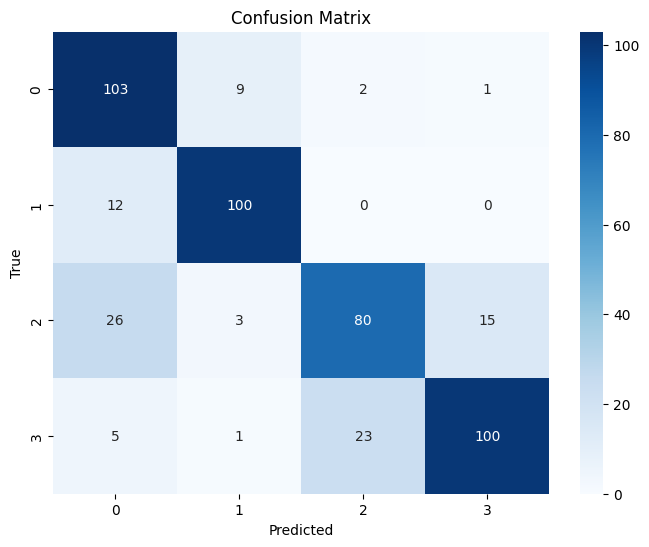

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
